In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import copy
from pprint import pprint
sys.path.insert(1, '../')

from JPEG import JPEG
from libs.JPEGStandardHuffmanTable import STD_HUFTAB_LUMIN_DC, STD_HUFTAB_CHROMIN_DC, STD_HUFTAB_LUMIN_AC, STD_HUFTAB_CHROMIN_AC
from libs.util import psnr

In [3]:
testImage_path = "../../_Dataset/Lenna/lena_color.gif"

jpeg = JPEG(testImage_path)
jpeg.setHuffmanTable(isAC=False, index=0, table=STD_HUFTAB_LUMIN_DC())
jpeg.setHuffmanTable(isAC=False, index=1, table=STD_HUFTAB_CHROMIN_DC())
jpeg.setHuffmanTable(isAC=True, index=0, table=STD_HUFTAB_LUMIN_AC())
jpeg.setHuffmanTable(isAC=True, index=1, table=STD_HUFTAB_CHROMIN_AC())

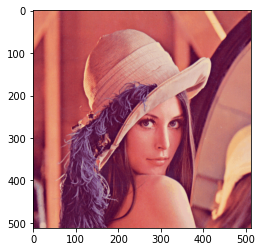

In [11]:
jpeg._img2ycbcr()

jpeg.block_size = 8
jpeg._ycbcrDCT()

jpeg.quality = 50
jpeg._ycbcrQuant()

Blocks = jpeg._ycbcrZigzag()

MCUs = jpeg._DPCMandRLE()

jpeg.showOriginImage()

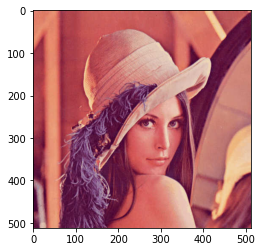

{'date': 1659719423.2178726,
 'file_path': 'lena_Q50.jpg',
 'size': (512, 512),
 'quality': 50,
 'file_size': 30149,
 'compression_ratio': '754.04%',
 'run_time': 1.124549388885498,
 'PSNR': 32.30588568793061}

In [77]:
jpeg_OriginBuilder = JPEG(testImage_path)

log = dict()
jpeg_image = jpeg_OriginBuilder.encode(quality=jpeg.quality, save_path="./lena_Q{}".format(jpeg.quality), finished_info=log)
plt.imshow(jpeg_image)
plt.show()
log

In [12]:
class Scheme_Huang():
    def __init__(self, block):
        self.block = np.array(block)
        self.rle = self.block[1:64]
        self.dpcm = self.block[0]

    def __initPrepare__(self, block):
        self.__init__(block)
        self.pre_Embedding()

    def getBlock(self):
        block = np.copy(self.block)
        block[0] = self.dpcm
        block[1:64] = self.rle
        return block

    def pre_Embedding(self):
        self.inner_index = np.argwhere((self.rle == 1) | (self.rle == -1))
        self.rle = self.rle + (self.rle > 1) - (self.rle < -1)
        self.block[1:64] = self.rle

    def freeSize(self):
        return self.inner_index.shape[0]

    def embedding(self, data):
        if len(data) > self.freeSize():
            raise Exception("The data size is bigger than the free size")

        # self.pre_Embedding()
        rle = np.copy(self.rle)
        for i in range(len(data)):
            # print(i, self.block[self.inner_index[i]])
            # self.block[self.inner_index[i]] = self.embed(self.block[self.inner_index[i]], int(data[i]))
            rle[self.inner_index[i]] = self.embed(self.rle[self.inner_index[i]], int(data[i]))

        self.block[1:64] = self.rle = rle
        return self.block

    def reStoring(self):
        rle = np.copy(self.rle).flatten()
        message = []
        for index in range(len(rle)):
            m = self.reSign(rle[index])
            rs = self.reStore(rle[index])
            rle[index] = rle[index] - (rs if m is None else rs*m)
            if m is not None:
                message.append(m)
        self.block[1:64] = self.rle = rle
        return self.block.reshape(self.block.shape), message

    @classmethod
    def sign(self, c_i):
        if c_i > 0:
            return 1
        elif c_i == 0:
            return 0
        elif c_i < 0:
            return -1
    @classmethod
    def reSign(self, c_i_p):
        if abs(c_i_p) == 1:
            return 0
        elif abs(c_i_p) == 2:
            return 1
        else:
            return None
    @classmethod
    def embed(self, c_i, s):
        if abs(c_i) == 1:
            return c_i + self.sign(c_i)*s
        elif abs(c_i) > 1:
            return c_i + self.sign(c_i)
    @classmethod
    def reStore(self, c_i_p):
        if abs(c_i_p) >= 1 & abs(c_i_p) <= 2:
            return self.sign(c_i_p)
        elif abs(c_i_p) >= 3:
            return c_i_p-self.sign(c_i_p)
        else:
            return 0

class Scheme_Extended():
    def __init__(self, block):
        self.block = np.array(block)
        self.dpcm = self.block[0]
        self.rle = self.block[1:64]

    def __initPrepare__(self, block):
        self.__init__(block)
        self.pre_Embedding()

    def getBlock(self):
        block = np.copy(self.block)
        block[0] = self.dpcm
        block[1:64] = self.rle
        return block

    def pre_Embedding(self):
        if np.any((self.rle == -3) | (self.rle == 3) | (self.rle == 4) | (self.rle == -4)):
            raise Exception("block contains -3, 3, 4, -4")
        self.inner_index = np.argwhere((self.rle == 1) | (self.rle == -1) | (self.rle == 2) | (self.rle == -2))

    def freeSize(self):
        return self.inner_index.shape[0]

    def embedding(self, data):
        if len(data) > self.freeSize():
            raise Exception("data size is not equal to free size")

        # self.pre_Embedding()
        rle = np.copy(self.rle)
        for i in range(len(data)):
            try:
                rle[self.inner_index[i]] = self.embed(self.rle[self.inner_index[i]], int(data[i]))
            except:
                print("self.inner_index[i]", self.inner_index[i])
                print("self.block[self.inner_index[i]]", self.rle[self.inner_index[i]])
                print("data[i]", data[i])
                raise Exception("error")
        # self.embedded_block = new_block
        self.block[1:64] = self.rle = rle
        # return self.embedded_block
        return self.block

    def reStoring(self):
        rle = np.copy(self.rle).flatten()
        message = []
        for index in range(len(rle)):
            if (abs(rle[index]) >= 1) & (abs(rle[index]) <= 4):
                m = self.reSign(rle[index])
                rs = self.reStore(rle[index])
                if m is not None:
                    rle[index] = rle[index] - rs
                    message.append(m)
        self.block[1:64] = self.rle = rle
        return self.block.reshape(self.block.shape), message
    @classmethod
    def sign(self, c_i):
        if c_i > 0:
            return 1
        elif c_i == 0:
            return 0
        elif c_i < 0:
            return -1
    @classmethod
    def reSign(self, c_i_p):
        if (abs(c_i_p) == 1) | (abs(c_i_p) == 3):
            return 0
        elif (abs(c_i_p) == 2) | (abs(c_i_p) == 4):
            return 1
        else:
            return None
    @classmethod
    def embed(self, c_i, s):
        if abs(c_i) == 1:
            return c_i + self.sign(c_i)*s
        elif abs(c_i) == 2:
            return c_i + self.sign(c_i)*(s+1)
        else:
            return c_i
    
    @classmethod
    def reStore(self, c_i_p):
        # if (abs(c_i_p) >= 1) & (abs(c_i_p) <= 2):
        #     return self.sign(c_i_p)
        # elif (abs(c_i_p) >= 3) & (abs(c_i_p) <= 4):
        #     return (self.sign(c_i_p)+(1 if c_i_p > 0 else -1))
        # else:
        #     return 0
        if (abs(c_i_p) == 2) | (abs(c_i_p) == 3):
            return self.sign(c_i_p)
        elif (abs(c_i_p) == 4):
            return 2*self.sign(c_i_p)
        else:
            return 0

In [13]:
class RDH():
    def __init__(self, blocks, T):
        self.zblocks = np.array(blocks) ## zigzaged blocks
        if T<0 or T>63:
            raise Exception("T is not in [0, 63]")
        self.T = T

    def embedBinaryMessage(self, message):
        if len(message) > self.freeSize():
            raise Exception("message size could not bigger than free size")

    def Huang(self):
        self.locationMap = []
        self.free_size = 0

        for zblock_index in range(len(self.zblocks)):
            for comp_block_index in range(len(self.zblocks[zblock_index])):
                block = self.zblocks[zblock_index][comp_block_index]
                innerC = self.numberOfInnerCoefficients(block, -1)
                if (innerC > 0) and innerC < self.T:
                    self.locationMap.append((-1, zblock_index, comp_block_index))
                    self.free_size += innerC

    def Divide_Into_TwoSet(self):
        self.locationMap = [] ## ([1: non-shifting, -1: shifting], zblock_index, comp_block_index)
        self.free_size = 0

        for zblock_index in range(len(self.zblocks)):
            for comp_block_index in range(len(self.zblocks[zblock_index])):
                block = self.zblocks[zblock_index][comp_block_index]
                shiftype = -1 if (np.any((block == -3) | (block == 3) | (block == 4) | (block == -4))) else 1
                innerC = self.numberOfInnerCoefficients(block, shiftype)
                if (innerC > 0) and (innerC < self.T):
                    self.locationMap.append((shiftype, zblock_index, comp_block_index))
                    self.free_size += innerC

    def Embedding(self, message):
        m_index = 0
        new_blocks = np.copy(self.zblocks)
        self.message_length = len(message)
        for type, zblock_index, comp_index in self.locationMap:
            if type == 1:
                sch = Scheme_Extended(self.zblocks[zblock_index][comp_index])
            elif type == -1:
                sch = Scheme_Huang(self.zblocks[zblock_index][comp_index])
            sch.pre_Embedding()
            inner_AC = sch.freeSize()
            if (m_index+inner_AC > len(message)):
                new_m_index = len(message)
            else:
                new_m_index = m_index+inner_AC
            sch.embedding(message[m_index:new_m_index])
            m_index = new_m_index
            new_blocks[zblock_index][comp_index] = sch.block
            if new_m_index == len(message):
                break

        self.embedded_zblocks = new_blocks
        return new_blocks

    def reStoring(self):
        new_blocks = np.copy(self.embedded_zblocks)
        message = []
        last_message_length = self.message_length
        n_i = 0
        for type, zblock_index, comp_index in self.locationMap:
            if type == 1:
                sch = Scheme_Extended(self.embedded_zblocks[zblock_index][comp_index])
            elif type == -1:
                sch = Scheme_Huang(self.embedded_zblocks[zblock_index][comp_index])
            # sch.pre_Embedding()
            reStored_block, m = sch.reStoring()
            new_blocks[zblock_index][comp_index] = reStored_block
            message.append("".join(str(i) for i in m))
            last_message_length -= len(message[-1])
            # print(n_i, last_message_length)
            n_i += 1
            if last_message_length < 0:
                print(n_i, last_message_length)
                break
        return new_blocks, "".join(message)[:self.message_length]
        # return new_blocks, "".join(message)


    @classmethod
    def numberOfInnerCoefficients(self, block, type):
        if type == 1:
            return self.numberOfInnerCoefficientsByExtended(block)
        elif type == -1:
            return self.numberOfInnerCoefficientsByHuang(block)

    @classmethod
    def numberOfInnerCoefficientsByHuang(self, block):
        rle = np.array(block)[1:64]
        return np.sum((rle == 1) | (rle == -1))

    @classmethod
    def numberOfInnerCoefficientsByExtended(self, block):
        rle = np.array(block)[1:64]
        return np.sum((rle == 1) | (rle == -1) | (rle == 2) | (rle == -2))

    def freeSize(self):
        # return len(self.locationMap[0])*2 + len(self.locationMap[1])*4
        return self.free_size

    def getNumberOfShiftingBlocks(self):
        return np.sum(np.array(list(zip(*np.array(self.locationMap)))[0]) == -1)

    def getNumberOfnonShiftingBlocks(self):
        return np.sum(np.array(list(zip(*np.array(self.locationMap)))[0]) == 1)

    def proportionOfShiftingBlocks(self):
        shifting = self.getNumberOfShiftingBlocks()
        nonShifting = self.getNumberOfnonShiftingBlocks()
        return shifting/(shifting+nonShifting)
    def proportionOfnonShiftingBlocks(self):
        shifting = self.getNumberOfShiftingBlocks()
        nonShifting = self.getNumberOfnonShiftingBlocks()
        return nonShifting/(shifting+nonShifting)

Tz = 15

rdh_propose = RDH(Blocks, T=Tz)
rdh_propose.Divide_Into_TwoSet()
print("propose scheme 載量=", rdh_propose.freeSize())
print("number of propose scheme block={}, rate={:.2f}".format(rdh_propose.getNumberOfnonShiftingBlocks(), rdh_propose.proportionOfnonShiftingBlocks()))
# M = np.random.randint(2, size=rdh_propose.freeSize())
M = np.random.randint(2, size=16000)
message = "".join(str(i) for i in M)
propose_Embedded = rdh_propose.Embedding(message)
propose_Restored, propose_Restored_message = rdh_propose.reStoring()


rdh_Huang = RDH(Blocks, T=Tz)
rdh_Huang.Huang()
print("Huang scheme 載量=", rdh_Huang.freeSize())
print("number of Huang scheme block={}, rate={:.2f}".format(rdh_Huang.getNumberOfShiftingBlocks(), rdh_Huang.proportionOfShiftingBlocks()))

# M = np.random.randint(2, size=rdh_Huang.freeSize())
M = np.random.randint(2, size=16000)
message = "".join(str(i) for i in M)
Huang_Embedded = rdh_Huang.Embedding(message)
Huang_Restored, Huang_Restored_message = rdh_Huang.reStoring()

propose scheme 載量= 23181
number of propose scheme block=5058, rate=0.68
5120 -9
Huang scheme 載量= 21206
number of Huang scheme block=7221, rate=1.00
5417 -6


In [42]:
# # type, zblock_index, comp_index = rdh.locationMap[1684]
# # rdh.zblocks[zblock_index][comp_index], rdh.embedded_zblocks[zblock_index][comp_index]

# test_Restored[0][0], Blocks[0][0]
# run_len = len(Blocks)
# for i in range(run_len):
#     for j in range(3):
#         # print(test_Restored[i], Blocks[I])
#         # break
#         eq = np.array_equal(test_Restored[i][j], Blocks[i][j])
#         if eq is False:
#             print("#", i, j)
#             print("## Blocks", Blocks[i][j])
#             print("## test_Restored", test_Embedded[i][j])
#             print("## test_Restored", test_Restored[i][j])
# # np.array_equal(test_Restored, Blocks)

# pprint((message, Restored_message))
# message == Restored_message

## Rebuilding the JPEG Image

C:\Users\BREND\AppData\Local\Temp\ipykernel_7684\2560864750.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  Origin_JPEGImage = imageio.imread("lena_Q{}.jpg".format(jpeg.quality))
C:\Users\BREND\AppData\Local\Temp\ipykernel_7684\2560864750.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  DHS_Huang_JPEGImage = imageio.imread("DHS_Huang_Q{}.jpg".format(jpeg.quality))
C:\Users\BREND\AppData\Local\Temp\ipykernel_7684\2560864750.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and 

Text(0.5, 1.0, "Propose's DHS JPEG Image, PSNR=39.4139")

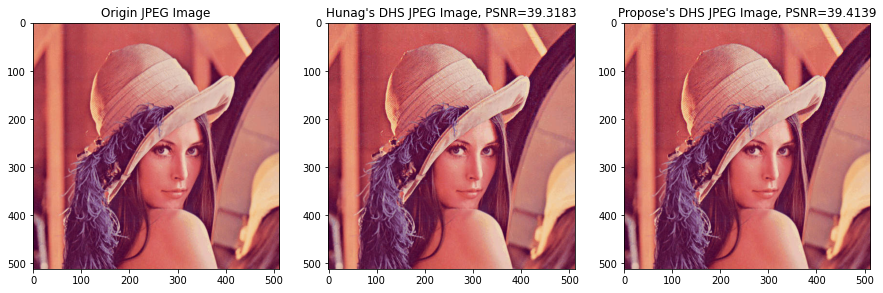

In [10]:
# # print(test_Embedded.shape, test_Restored.shape)


jpeg_propse = jpeg
jpeg_Huang = copy.deepcopy(jpeg)
# jpeg.zigzag = test_Restored
jpeg_propse.zigzag = propose_Embedded
jpeg_propse._DPCMandRLE()
jpeg_propse.HuffmanTableBuilding(HuffmanTableTypeIndex=jpeg_propse.HuffmanTableTypeIndex)
jpeg_propse._HuffmanEncoding()
jpeg_propse._EntropyCodedStgment()
jpeg_propse._writeToFile(save_path="./DHS_Propose_Q{}".format(jpeg.quality))

jpeg_Huang.zigzag = Huang_Embedded
jpeg_Huang._DPCMandRLE()
jpeg_Huang.HuffmanTableBuilding(HuffmanTableTypeIndex=jpeg_Huang.HuffmanTableTypeIndex)
jpeg_Huang._HuffmanEncoding()
jpeg_Huang._EntropyCodedStgment()
jpeg_Huang._writeToFile(save_path="./DHS_Huang_Q{}".format(jpeg.quality))

Origin_JPEGImage = imageio.imread("lena_Q{}.jpg".format(jpeg.quality))
DHS_Huang_JPEGImage = imageio.imread("DHS_Huang_Q{}.jpg".format(jpeg.quality))
DHS_propose_JPEGImage = imageio.imread("DHS_Propose_Q{}.jpg".format(jpeg.quality))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(Origin_JPEGImage)
axs[0].set_title("Origin JPEG Image")
axs[1].imshow(DHS_Huang_JPEGImage)
axs[1].set_title("Hunag's DHS JPEG Image, PSNR={:.4f}".format(psnr(Origin_JPEGImage, DHS_Huang_JPEGImage)))
axs[2].imshow(DHS_propose_JPEGImage)
axs[2].set_title("Propose's DHS JPEG Image, PSNR={:.4f}".format(psnr(Origin_JPEGImage, DHS_propose_JPEGImage)))

## Shifing

In [325]:
Original_Shifing_Block = [
    187, 67, -39, 0, -6, 2, 1, 0,
    -3, 2, 2, -3, -1, 0, 0, 0,
    1, 0, -2, 1, 0, 0, 0, 1,
    0,0,0,0,0,0,0,0,
    0, 1, 0, 0, 0, 0, 0, 0,
    -1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0
]
test = rdh.Scheme_Huang(Original_Shifing_Block)
test.block.reshape(8, 8)

array([[187,  67, -39,   0,  -6,   2,   1,   0],
       [ -3,   2,   2,  -3,  -1,   0,   0,   0],
       [  1,   0,  -2,   1,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0],
       [ -1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]])

In [326]:
test.pre_Embedding()
test.embedding("1001100")
test.block.reshape(8, 8)

array([[187,  68, -40,   0,  -7,   3,   2,   0],
       [ -4,   3,   3,  -4,  -1,   0,   0,   0],
       [  1,   0,  -3,   2,   0,   0,   0,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0],
       [ -1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]])

In [327]:
c_pp, message = test.reStoring()
message, c_pp.reshape(8, 8)

block rs, m


([1, 0, 0, 1, 1, 0, 0],
 array([[187,  67, -39,   0,  -6,   2,   1,   0],
        [ -3,   2,   2,  -3,  -1,   0,   0,   0],
        [  1,   0,  -2,   1,   0,   0,   0,   1],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   1,   0,   0,   0,   0,   0,   0],
        [ -1,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]]))

In [328]:
np.array_equal(c_pp, Original_Shifing_Block)

True

## non-Shifing

In [432]:
Original_nonShifing_Block = [
    200, 39, -39, 6, -6, 2, 0, 0,
    -5, 12, -8, -2, 2, 0, 0, 0,
    0, -1, 2, -1, 0, 1, 0, 0,
    1, 0, -1, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0
]
test = rdh.Scheme_Extended(Original_nonShifing_Block)
test.block.reshape(8, 8)

array([[200,  39, -39,   6,  -6,   2,   0,   0],
       [ -5,  12,  -8,  -2,   2,   0,   0,   0],
       [  0,  -1,   2,  -1,   0,   1,   0,   0],
       [  1,   0,  -1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]])

In [433]:
test.pre_Embedding()
test.embedding("100110001")
test.block.reshape(8, 8)

array([[200,  39, -39,   6,  -6,   4,   0,   0],
       [ -5,  12,  -8,  -3,   3,   0,   0,   0],
       [  0,  -2,   4,  -1,   0,   1,   0,   0],
       [  1,   0,  -2,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0]])

In [434]:
c_pp, message = test.reStoring()
message, c_pp.reshape(8, 8)

# 5
## block 4
## m=1, rs=2
# 11
## block -3
## m=0, rs=-1
# 12
## block 3
## m=0, rs=1
# 17
## block -2
## m=1, rs=-1
# 18
## block 4
## m=1, rs=2
# 19
## block -1
## m=0, rs=0
# 21
## block 1
## m=0, rs=0
# 24
## block 1
## m=0, rs=0
# 26
## block -2
## m=1, rs=-1


([1, 0, 0, 1, 1, 0, 0, 0, 1],
 array([[200,  39, -39,   6,  -6,   2,   0,   0],
        [ -5,  12,  -8,  -2,   2,   0,   0,   0],
        [  0,  -1,   2,  -1,   0,   1,   0,   0],
        [  1,   0,  -1,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]]))

In [435]:
np.array_equal(c_pp, Original_nonShifing_Block)

True

## Message

In [ ]:
np.random.randint(2, size=100)

## 2.2 Huang et al.’s data hiding scheme
Huang et al. found that the vast majority ofthe non-zero AC coefficients in JPEG images with varying QFs have a value of +1 or − 1. Since the histogram of non-zero AC coefficients is sharp with peaks at the locations of +1 and − 1, respectively, Huang et al. applied histogram shifting to embed data into the quantized DCT coefficients.

Can embed data of 21206 bits.


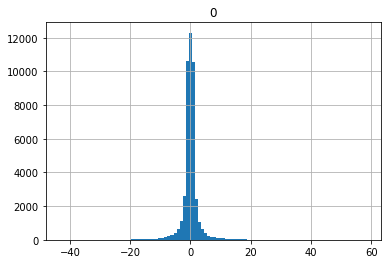

In [97]:


data = []
for mcu in MCUs:
    for comp in mcu:
        for rle in comp["RLE"]:
            # if rle[0] == 0:
            #     data.append(rle[1])
            data.append(rle[1])

df = pd.DataFrame(data)
hist = df.hist(bins=10)
S = df.stack().value_counts()[1] + df.stack().value_counts()[-1]
print("Can embed data of {} bits.".format(S))

## SBMBTC: Single Bitmap BTC
- 4*4 block need 64bit
  - 16bit bitmap
  - 8+8 a_R, b_R
  - 8+8 a_G, b_G
  - 8+8 a_B, b_B

512*512/16*4 = (512*512)/4 = 65536


## SBMBTC QLremove2
- 4*4 block need 47bit
  - 16bit bitmap
  - 6+5 a_R, b_R
  - 6+5 a_G, b_G
  - 6+5 a_B, b_B

512*512/16

## Main Process
1. DCT the blocks
2. divide them into two sets: 
   1. non-shifting blocks: embed data by Extended method
      - No AC coefficients with values in (3, -3, 4, -4)
   2. shifting blocks: embed data by Huang's method
## The auxiliary information
- location map
- message length
- threshold T_z

In [8]:
def sign(c_i):
    if c_i > 0:
        return 1
    elif c_i == 0:
        return 0
    elif c_i < 0:
        return -1

def deSign(c_i_p):
    if abs(c_i_p) == 1:
        return 0
    elif abs(c_i_p) == 2:
        return 1

def embedding(c_i, s):
    if abs(c_i) == 1:
        return c_i + sign(c_i)*s
    elif abs(c_i) > 1:
        return c_i + sign(c_i)

def reStoration(c_i_p):
    if abs(c_i_p) >= 1 & abs(c_i_p) <= 2:
        return sign(c_i_p)
    elif abs(c_i_p) >= 3:
        return c_i_p-sign(c_i_p)

In [59]:


Original_Shifing_Block = [
    187, 67, -39, 0, -6, 2, 1, 0,
    -3, 2, 2, -3, -1, 0, 0, 0,
    1, 0, -2, 1, 0, 0, 0, 1,
    0,0,0,0,0,0,0,0,
    0, 1, 0, 0, 0, 0, 0, 0,
    -1, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0, 0
]

rle = jpeg.RLE(arr=np.array(Original_Shifing_Block)[1:64])
rle

array([[  0,  67],
       [  0, -39],
       [  1,  -6],
       [  0,   2],
       [  0,   1],
       [  1,  -3],
       [  0,   2],
       [  0,   2],
       [  0,  -3],
       [  0,  -1],
       [  3,   1],
       [  1,  -2],
       [  0,   1],
       [  3,   1],
       [  9,   1],
       [  6,  -1],
       [  0,   0]])

In [60]:
def preEmbeddingRLE_by_Huang(mcu_RLE):
    preEmbeddingIndex_list = []
    _RLE = np.array(mcu_RLE)
    for index in range(len(_RLE)):
        _RLE[index][1] += 1 if _RLE[index][1]>1 else (-1 if _RLE[index][1]<-1 else 0)
        if abs(_RLE[index][1]) == 1:
            preEmbeddingIndex_list.append(index)

    return _RLE, preEmbeddingIndex_list

def preEmbeddingBlock_by_Huang(block):
    preEmbeddingIndex_list = []
    _block = np.array(block).flatten()
    for index in range(1, len(_block)):
        if abs(_block[index]) == 1:
            preEmbeddingIndex_list.append(index)
        elif _block[index] > 1:
            _block[index] += 1
        elif _block[index] < -1:
            _block[index] -= 1

    return _block.reshape((8, 8)), preEmbeddingIndex_list

preEmbeddingRLE_by_Huang(rle), preEmbeddingBlock_by_Huang(Original_Shifing_Block)

_block 64 [187  67 -39   0  -6   2   1   0  -3   2   2  -3  -1   0   0   0   1   0
  -2   1   0   0   0   1   0   0   0   0   0   0   0   0   0   1   0   0
   0   0   0   0  -1   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


((array([[  0,  68],
         [  0, -40],
         [  1,  -7],
         [  0,   3],
         [  0,   1],
         [  1,  -4],
         [  0,   3],
         [  0,   3],
         [  0,  -4],
         [  0,  -1],
         [  3,   1],
         [  1,  -3],
         [  0,   1],
         [  3,   1],
         [  9,   1],
         [  6,  -1],
         [  0,   0]]),
  [4, 9, 10, 12, 13, 14, 15]),
 (array([[187,  68, -40,   0,  -7,   3,   1,   0],
         [ -4,   3,   3,  -4,  -1,   0,   0,   0],
         [  1,   0,  -3,   1,   0,   0,   0,   1],
         [  0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   1,   0,   0,   0,   0,   0,   0],
         [ -1,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0]]),
  [6, 12, 16, 19, 23, 33, 40]))

In [61]:
def embedding_Extended(c_i, s):
    if abs(c_i) == 1:
        return c_i + sign(c_i)*s
    elif abs(c_i) == 2:
        return c_i + sign(c_i)*(s+1)
    else:
        return c_i

def deSign_Extended(c_i_p):
    if abs(c_i_p) == 1 | abs(c_i_p) == 3:
        return 0
    elif abs(c_i_p) == 2 | abs(c_i_p) == 4:
        return 1

def reStoration_Extended(c_i_p):
    if abs(c_i_p)>=1 & abs(c_i_p)<=2:
        return sign(c_i_p)
    elif abs(c_i_p)>=3 & abs(c_i_p)<=4:
        return 2*sign(c_i_p)
    else:# c_i_p will not be 0
        return c_i_p

def preEmbeddingBlock_by_extended(block):
    preEmbeddingIndex_list = []
    _block = np.array(block).flatten()
    for index in range(1, len(_block)):
        if abs(_block[index]) == 1:
            preEmbeddingIndex_list.append(index)

    return _block.reshape((8, 8)), preEmbeddingIndex_list

preEmbeddingBlock_by_extended(Original_Shifing_Block)

(array([[187,  67, -39,   0,  -6,   2,   1,   0],
        [ -3,   2,   2,  -3,  -1,   0,   0,   0],
        [  1,   0,  -2,   1,   0,   0,   0,   1],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   1,   0,   0,   0,   0,   0,   0],
        [ -1,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0]]),
 [6, 12, 16, 19, 23, 33, 40])

In [ ]:
c_i = 1